In [1]:
# If your dataset lives on Google Drive, mount it first
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:

# Set the base directory to your processed dataset
BASE_DIR = '/content/drive/MyDrive/42028AUT2025/assignment3/ColumbiaGazeProcessed/ColumbiaGazeProcessed'

In [3]:
!unzip -q "/content/drive/MyDrive/42028AUT2025/assignment3/ColumbiaGazeProcessed.zip" \
        -d "/content/drive/MyDrive/42028AUT2025/assignment3/ColumbiaGazeProcessed"

In [4]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import f1_score, confusion_matrix, classification_report

# 1) Fix random seed for reproducibility
SEED = 42028
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 2) Hyperparameters
IMG_SIZE   = (96, 96)
BATCH_SIZE = 32
LR         = 1e-3
EPOCHS     = 100
AUTOTUNE   = tf.data.AUTOTUNE


In [5]:
# Use Keras utility to read from folder-structured dirs.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(BASE_DIR, 'train'),
    labels='inferred', label_mode='categorical',
    image_size=IMG_SIZE, batch_size=BATCH_SIZE,
    shuffle=True, seed=SEED
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(BASE_DIR, 'val'),
    labels='inferred', label_mode='categorical',
    image_size=IMG_SIZE, batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(BASE_DIR, 'test'),
    labels='inferred', label_mode='categorical',
    image_size=IMG_SIZE, batch_size=BATCH_SIZE,
    shuffle=False
)


Found 4125 files belonging to 9 classes.
Found 912 files belonging to 9 classes.
Found 886 files belonging to 9 classes.


In [6]:
def preprocess(image, label):
    """Normalize pixel values to [0,1]."""
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE) \
                   .cache().shuffle(1000, seed=SEED).prefetch(AUTOTUNE)
val_ds   = val_ds.map(preprocess, num_parallel_calls=AUTOTUNE) \
                 .cache().prefetch(AUTOTUNE)
test_ds  = test_ds.map(preprocess, num_parallel_calls=AUTOTUNE) \
                  .cache().prefetch(AUTOTUNE)


In [7]:
# 1) Create the raw dataset and grab the class names
raw_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(BASE_DIR, 'train'),
    labels='inferred', label_mode='categorical',
    image_size=IMG_SIZE, batch_size=BATCH_SIZE,
    shuffle=True, seed=SEED
)
class_names = raw_train_ds.class_names
NUM_CLASSES = len(class_names)

# 2) Now build your preprocessing pipeline on raw_train_ds
train_ds = raw_train_ds.map(preprocess, num_parallel_calls=AUTOTUNE) \
                       .cache().shuffle(1000, seed=SEED).prefetch(AUTOTUNE)

# 3) Same for val_ds/test_ds (but you don’t need class_names from them)
raw_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(BASE_DIR, 'val'),
    labels='inferred', label_mode='categorical',
    image_size=IMG_SIZE, batch_size=BATCH_SIZE,
    shuffle=False
)
val_ds = raw_val_ds.map(preprocess, num_parallel_calls=AUTOTUNE) \
                   .cache().prefetch(AUTOTUNE)

raw_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(BASE_DIR, 'test'),
    labels='inferred', label_mode='categorical',
    image_size=IMG_SIZE, batch_size=BATCH_SIZE,
    shuffle=False
)
test_ds = raw_test_ds.map(preprocess, num_parallel_calls=AUTOTUNE) \
                     .cache().prefetch(AUTOTUNE)

# 4) Build model using NUM_CLASSES
from tensorflow.keras import Input

model = models.Sequential([
    Input(shape=(*IMG_SIZE, 3)),            # use Input to avoid the warning
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()



Found 4125 files belonging to 9 classes.
Found 912 files belonging to 9 classes.
Found 886 files belonging to 9 classes.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,921 (433.29 KB)

 Trainable params: 110,921 (433.29 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,            # stop if no improvement in 10 epochs
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,            # reduce LR if no improvement in 5 epochs
        verbose=1
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,           # now up to 100
    callbacks=callbacks
)


Epoch 1/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1391s 2s/step - accuracy: 0.1496 - loss: 2.1286 - val_accuracy: 0.1371 - val_loss: 2.1006 - learning_rate: 0.0010
Epoch 2/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1437 - loss: 2.1085 - val_accuracy: 0.1820 - val_loss: 2.0967 - learning_rate: 0.0010
Epoch 3/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1560 - loss: 2.1016 - val_accuracy: 0.2083 - val_loss: 2.0626 - learning_rate: 0.0010
Epoch 4/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2132 - loss: 2.0565 - val_accuracy: 0.1930 - val_loss: 2.0024 - learning_rate: 0.0010
Epoch 5/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2195 - loss: 2.0035 - val_accuracy: 0.2215 - val_loss: 1.9844 - learning_rate: 0.0010
Epoch 6/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2334 - loss: 1.9999 - val_accuracy: 0.2127 - val_loss: 1.9752 - learning_rate: 0.0010
Epoch 7/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2272 - loss

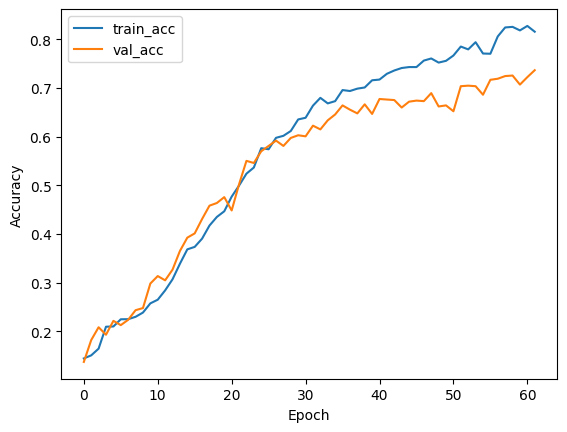

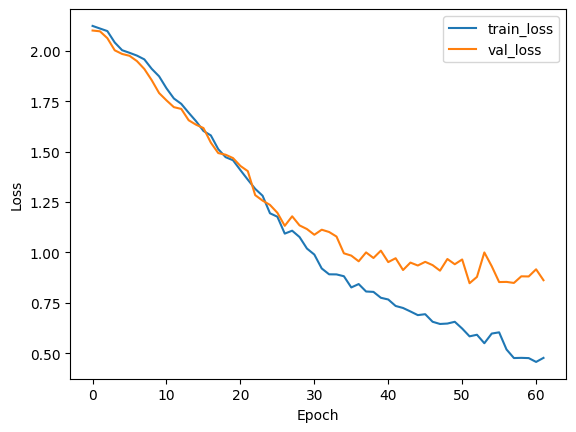

In [9]:
import matplotlib.pyplot as plt

# Plot train & val accuracy
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot train & val loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [10]:


# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_ds)

# Print the accuracies
print(f'Train Accuracy: {history.history["accuracy"][-1]:.4f}')
print(f'Validation Accuracy: {history.history["val_accuracy"][-1]:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

28/28 ━━━━━━━━━━━━━━━━━━━━ 283s 10s/step - accuracy: 0.6376 - loss: 0.8198
Train Accuracy: 0.8160
Validation Accuracy: 0.7368
Test Accuracy: 0.7607


In [11]:
# 1) Get raw predictions on test set
y_true = []
y_pred = []

for imgs, labels in test_ds:
    preds = model.predict(imgs)
    y_true.extend(tf.argmax(labels, axis=1).numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

# 2) Compute Accuracy, F1-score, Confusion Matrix
acc = np.mean(np.array(y_true) == np.array(y_pred))
f1 = f1_score(y_true, y_pred, average='weighted')
cm = confusion_matrix(y_true, y_pred)

print(f"Test Accuracy : {acc:.4f}")
print(f"Weighted F1    : {f1:.4f}")
print("Classification Report:\n", classification_report(y_true, y_pred))
print("Confusion Matrix:\n", cm)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━